In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [35]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [37]:
def build_model(hp):
    model = keras.Sequential()

    # Define the number of convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=2, max_value=8, step=2)

    model.add(layers.Conv2D(
        hp.Int('conv1_filters', min_value=256, max_value=1024, step=128),
        (3, 3),
        activation='relu',
        padding='same',
        input_shape=X_train.shape[1:]
    ))

    # Add convolutional layers
    for i in range(num_conv_layers):
        model.add(layers.Conv2D(
            hp.Int(f'conv{i+1}_filters', min_value=128, max_value=1024, step=128),
            (3, 3),
            activation='relu',
            padding='same',
        ))

        # Add max pooling layer
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Add dropout layer
        model.add(layers.Dropout(hp.Float(f'dropout{i+1}', min_value=0.0, max_value=0.5, step=0.1)))

    # Flatten the output layer
    model.add(layers.Flatten())

    # Add dense layer
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=1024, step=128),
        activation='relu',
    ))

    # Add dropout layer
    model.add(layers.Dropout(0.2))

    # Add the output layer
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [40]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir_new',
    project_name='helloworld'
)


In [41]:
# You can print a summary of the search space:
tuner.search_space_summary()
# The call to search has the same signature as model.fit()
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
# When search is over, you can retrieve the best model(s):
models = tuner.get_best_models(num_models=2)
# Or print a summary of the results:
tuner.results_summary()

Trial 5 Complete [00h 05m 30s]
val_accuracy: 0.7398999929428101

Best val_accuracy So Far: 0.7398999929428101
Total elapsed time: 00h 48m 23s
Results summary
Results in my_dir_new/helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
num_conv_layers: 4
conv1_filters: 384
dropout1: 0.0
conv2_filters: 128
dropout2: 0.1
dense_units: 320
conv3_filters: 128
dropout3: 0.0
conv4_filters: 256
dropout4: 0.0
conv5_filters: 896
dropout5: 0.0
conv6_filters: 640
Score: 0.7398999929428101
Trial summary
Hyperparameters:
num_conv_layers: 2
conv1_filters: 512
dropout1: 0.1
conv2_filters: 768
dropout2: 0.0
dense_units: 448
conv3_filters: 1024
dropout3: 0.0
conv4_filters: 256
dropout4: 0.0
conv5_filters: 384
dropout5: 0.4
conv6_filters: 512
Score: 0.7394000291824341
Trial summary
Hyperparameters:
num_conv_layers: 2
conv1_filters: 640
dropout1: 0.2
conv2_filters: 128
dropout2: 0.4
dense_units: 192
conv3_filters: 512
dropout3: 0.1
conv4_filters: 256
dropout4: 0.2
conv5_filters: 128
dropout5: 0.3

In [42]:
best_model = tuner.get_best_models(num_models=1)[0]

In [44]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 384)       10752     
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 384)       1327488   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 384)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 384)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       442496    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                    

In [45]:
# Evaluate the model
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.7624671459197998
Test accuracy: 0.7398999929428101


In [47]:
import numpy as np

In [48]:
# Use the trained model to predict class labels for some test data
y_pred = best_model.predict(X_test)

# Convert the predicted probabilities into class labels
y_pred_labels = [np.argmax(pred) for pred in y_pred]

# Convert the one-hot encoded actual labels into class labels
y_test_labels = [np.argmax(label) for label in y_test]

# Print some predicted and actual labels to check the model's performance
print('Predicted labels:', y_pred_labels[:10])
print('Actual labels:', y_test_labels[:10])

313/313 [==============================] - 3s 10ms/step
Predicted labels: [3, 8, 8, 8, 6, 6, 1, 4, 3, 1]
Actual labels: [3, 8, 8, 0, 6, 6, 1, 6, 3, 1]


1/1 [==============================] - 0s 362ms/step


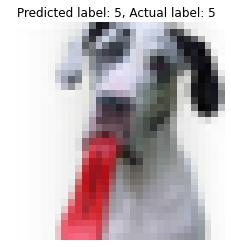

In [49]:
import matplotlib.pyplot as plt
# Select a random test image
idx = np.random.randint(len(X_test))
img = X_test[idx]
label = y_test_labels[idx]

# Use the trained model to predict the class label of the selected image
pred = best_model.predict(np.expand_dims(img, axis=0))
pred_label = np.argmax(pred)

# Display the image and its predicted label
plt.imshow(img)
plt.title(f'Predicted label: {pred_label}, Actual label: {label}')
plt.axis('off')
plt.show()